In [1]:
import sys
import os
import gc
import sqlite3
import lightgbm as lgb
import numpy as np
import pandas as pd

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from database.dataset.new_data import DataBuilder
from database.connection import sql_connection
from pathlib import Path
from skopt.space import Real, Integer
from modules.interface import RunModel, RunOptimization
from plots import plots

In [2]:
# Extrair dados do terceiro arquivo SQLite

# Base robusta: script OU notebook
try:
    BASE_DIR = Path(__file__).resolve().parent
except NameError:
    # Jupyter / IPython
    BASE_DIR = Path.cwd()

# Voltar um diretório e entrar em database/data/lorenzetti
LORENZETTI_DIR = (BASE_DIR / '..' / 'database' / 'data' / 'lorenzetti').resolve()

qrings_dataframe = pd.concat(
    [
        sql_connection.extrair_dados_sqlite(LORENZETTI_DIR / 'StdRings.db', 'events'),
        sql_connection.extrair_dados_sqlite(LORENZETTI_DIR / 'QRings.db', 'events'),
        sql_connection.extrair_dados_sqlite(LORENZETTI_DIR / 'ClusterData.db', 'events')
    ],
    axis=1
)

gc.collect()

std_dataframe = pd.concat(
    [
        sql_connection.extrair_dados_sqlite(LORENZETTI_DIR / 'StdRings.db', 'events'),
        sql_connection.extrair_dados_sqlite(LORENZETTI_DIR / 'ClusterData.db', 'events')
    ],
    axis=1
)

gc.collect()

0

In [4]:
# Definição dos bins de entrada
bins_et = {'cluster_et':[5000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 150000, 200000, 250000, 900000, 3000000]}
bins_eta = {'cluster_eta':[0, 0.6, 0.8, 1.2, 1.37, 1.52, 1.8, 2.0, 2.2, 2.5]}
# # Lista para armazenar o resultado final
# params = []
#params=[[{'cluster_eta':[0.6, 0.8]}, {'cluster_et':[20000,30000]}]]

qrings_data=DataBuilder(
    dataframe=qrings_dataframe,
    bins_et=bins_et,
    bins_eta=bins_eta
    ).run(
    topology='quarter_rings', 
    train_size=0.7, 
    random_state=1, 
    model='default', 
    bins_size=None
    )

std_data=DataBuilder(
    dataframe=std_dataframe,
    bins_et=bins_et,
    bins_eta=bins_eta
    ).run(
    topology='raw', 
    train_size=0.7, 
    random_state=1, 
    model='default', 
    bins_size=None
    )

[quarter_rings] Executando Quarter Rings (default)...
(66677, 974)
[raw] Executando lógica Raw Default...
new_processing_print ['StdRings_0', 'StdRings_1', 'StdRings_2', 'StdRings_3', 'StdRings_4', 'StdRings_5', 'StdRings_6', 'StdRings_7', 'StdRings_8', 'StdRings_9', 'StdRings_10', 'StdRings_11', 'StdRings_12', 'StdRings_13', 'StdRings_14', 'StdRings_15', 'StdRings_16', 'StdRings_17', 'StdRings_18', 'StdRings_19', 'StdRings_20', 'StdRings_21', 'StdRings_22', 'StdRings_23', 'StdRings_24', 'StdRings_25', 'StdRings_26', 'StdRings_27', 'StdRings_28', 'StdRings_29', 'StdRings_30', 'StdRings_31', 'StdRings_32', 'StdRings_33', 'StdRings_34', 'StdRings_35', 'StdRings_36', 'StdRings_37', 'StdRings_38', 'StdRings_39', 'StdRings_40', 'StdRings_41', 'StdRings_42', 'StdRings_43', 'StdRings_44', 'StdRings_45', 'StdRings_46', 'StdRings_47', 'StdRings_48', 'StdRings_49', 'StdRings_50', 'StdRings_51', 'StdRings_52', 'StdRings_53', 'StdRings_54', 'StdRings_55', 'StdRings_56', 'StdRings_57', 'StdRings_58

In [7]:
space_lgbm = [
    Real(name='learning_rate', low = 0.01 , high = 0.9),
    Integer(name='num_leaves', low = 200, high = 1000),
    Integer(name='max_depth', low = 200, high = 1000),
    Real(name='feature_fraction', low = 0.5 , high = 1),
    Real(name='bagging_fraction', low = 0.7 , high = 1),
    Integer(name='bagging_freq', low = 1, high = 10),
    Real(name='lambda_l1',low = 0.0, high = 1),
    Real(name='lambda_l2',low = 0.5, high = 1)
]

fixed_params_lgbm = {
    "boosting_type": "gbdt",
    'objective': 'mae', 
    'metric': 'mae', 
    'num_iterations ': 200,
    'random_state': 1, 
    'n_jobs': -1, 
    'verbose': -1
}

calibration_kwargs = {'callbacks':[lgb.early_stopping(stopping_rounds=5, verbose=False)]}
optimization_kwargs = {'n_initial_points': 1,
                        'n_calls': 2,
                        'initial_point_generator': 'lhs',
                        'random_state': 1,

                       
                       }

qrings_optimizer_lgbm = RunOptimization()
r1=qrings_optimizer_lgbm.run(opt_class='gp_minimize',
    model_class="lgbm",
    datasets=qrings_data,
    space=space_lgbm, 
    fixed_params=fixed_params_lgbm,
    metric='mae',
    calibration_kwargs=calibration_kwargs,
    optimization_kwargs= optimization_kwargs
)

std_optimizer_lgbm = RunOptimization()
r2=std_optimizer_lgbm.run(opt_class='gp_minimize',
    model_class="lgbm",
    datasets=std_data,
    space=space_lgbm, 
    fixed_params=fixed_params_lgbm,
    metric='mae',
    calibration_kwargs=calibration_kwargs,
    optimization_kwargs= optimization_kwargs
)

# PLOT

/media/ricardo/HD/Doutorado/calibration/calibration_refactor/calibration_refactor_main/venv/lib/python3.13/site-packages/matplotlib/axes/_axes.py:3831: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


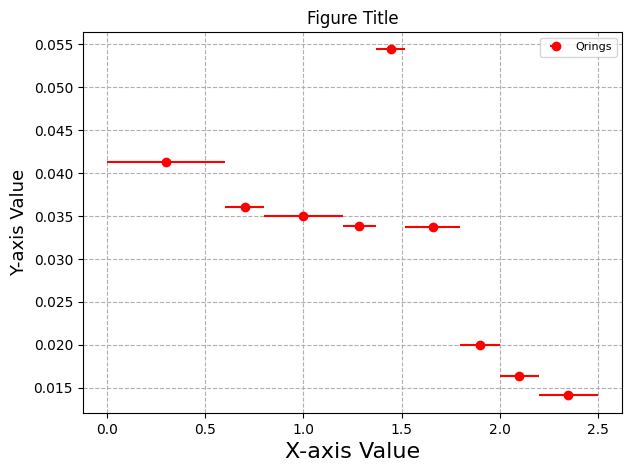

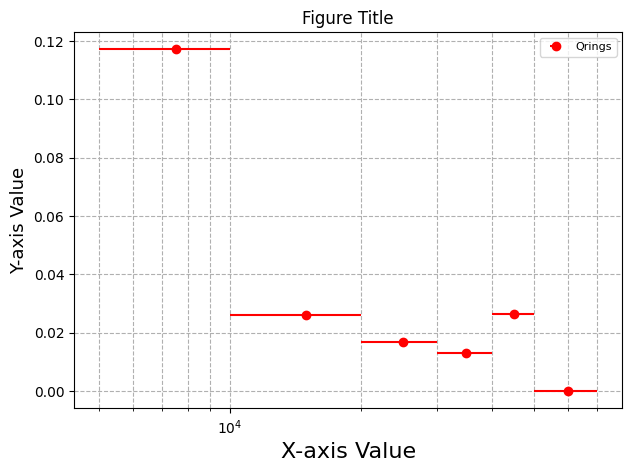

In [8]:
config=[{'label':'Qrings',
         'fmt':'o',
         'color':'r'}]

plot_eta=plots.PlotConfig(qrings_optimizer_lgbm.optimizer, qrings_dataframe, bins_eta)
plot_eta.plot_errorbars(plot_eta._set_plot(), config)

plot_et=plots.PlotConfig(qrings_optimizer_lgbm.optimizer, qrings_dataframe, bins_et)
plot_et.plot_errorbars(plot_et._set_plot(), config, xscale='log')